In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape

print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


### Project Overview


The goal of this project is to build the generator portion of a GAN Model to generate Monet-style paintings. The goal is that we can construct a DCGAN generator that generates similar enough Monet style images, that the discriminator classifies these fake images as real. Hypothetically, we could then use these DCGAN generated images as supplemental data and labels to a supervised learning problem. 

The included dataset contains 300 existing Monet paintings to serve as the domain for the discriminator to learn from. There are ~7k baseline images that I will train the generator with to produce the fake Monet style paintings; each of these baseline images has a dimension *256x256x3* pixels. 


NOTE: The preprocessing and helper functions used throughout this notebook were laregely adapted from existing online resources that deal with image processing 

#### Loading in images

In [3]:
# monet_jpgs = []
# for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/monet_jpg'):
#     for filename in filenames:
#         image = io.imread(os.path.join(dirname, filename))
#         monet_jpgs.append(image)
        
# source_jpgs = []
# for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/photo_jpg'):
#     for filename in filenames:
#         image = io.imread(os.path.join(dirname, filename))
        
#         source_jpgs.append(image)

photo_path_tfrec = f"/kaggle/input/gan-getting-started/photo_tfrec"
monet_path_tfrec = f"/kaggle/input/gan-getting-started/monet_tfrec"

photo_files_tfrec = sorted(tf.io.gfile.glob(f"{photo_path_tfrec}/*.tfrec"))
monet_files_tfrec = sorted(tf.io.gfile.glob(f"{monet_path_tfrec}/*.tfrec"))

photo_files_tfrds = tf.data.TFRecordDataset(photo_files_tfrec)
monet_files_tfrds = tf.data.TFRecordDataset(monet_files_tfrec)

In [4]:
photo_files_tfrds = tf.data.TFRecordDataset(photo_files_tfrec)
monet_files_tfrds = tf.data.TFRecordDataset(monet_files_tfrec)

In [5]:
print('Photo .tfrec files count:', len(photo_files_tfrec))


Photo .tfrec files count: 20


In [8]:
# viz helper functions
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def plot_tfrec_image(record, image_feature, extra_features=[]):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    image = tf.image.decode_jpeg(
        example.features.feature[image_feature].bytes_list.value[0],
        channels=3
    )
    for feature in extra_features:
        print('Image type:\t', example.features.feature[feature].bytes_list.value[0].decode('utf-8'))
    plot_image(image)

Image type:	 photo
Image type:	 ad24506f8b


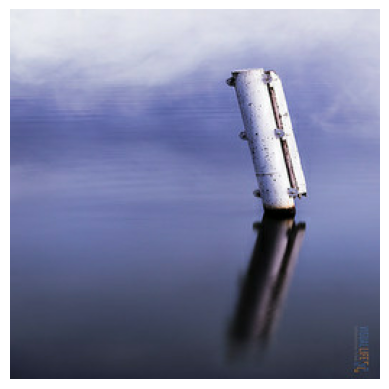

Image type:	 monet
Image type:	 ad8ce41fc0


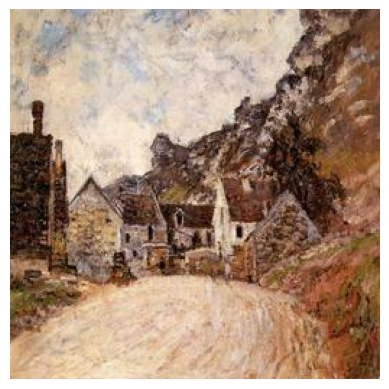

In [11]:
# showing a source image and a monet image to get a sense of the images we are working with
plot_tfrec_image(
    next(iter(photo_files_tfrds.skip(np.random.randint(0,7038)))),
    'image', ['target', 'image_name']
)

plot_tfrec_image(
    next(iter(monet_files_tfrds.skip(np.random.randint(0,300)))),
    'image', ['target', 'image_name']
)

### Processing Data Images

In [18]:
BATCH_SIZE = 32
TEST_BATCH_SIZE = 128
def decode_image(image):
    shape = [256, 256, 3]
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, shape)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=-1)
    return dataset

def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[BATCH_SIZE, 256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    return image

In [30]:
def prepare_gan_ds(photo_files, monet_files, augment_fn=None, repeat=True, shuffle=True, cache=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    if cache:
        monet_ds = monet_ds.cache()
        photo_ds = photo_ds.cache()
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds_entries = monet_ds.reduce(0, lambda x,_: x+1).numpy()
        photo_ds_entries = photo_ds.reduce(0, lambda x,_: x+1).numpy()
        monet_ds = monet_ds.shuffle(monet_ds_entries)
        photo_ds = photo_ds.shuffle(photo_ds_entries)
    monet_ds = monet_ds.batch(batch_size)
    photo_ds = photo_ds.batch(batch_size)
    if augment_fn:
        monet_ds = monet_ds.map(augment_fn, num_parallel_calls=-1)
        photo_ds = photo_ds.map(augment_fn, num_parallel_calls=-1)
    monet_ds = monet_ds.prefetch(-1)
    photo_ds = photo_ds.prefetch(-1)
    gan_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
    return gan_ds


train_ds = prepare_gan_ds(
    photo_files_tfrec,
    monet_files_tfrec,
    augment_fn=data_augment,
    repeat=True,
    shuffle=False,
    cache=False,
    batch_size=BATCH_SIZE
)
test_photo_ds = load_dataset(photo_files_tfrec).batch(TEST_BATCH_SIZE).prefetch(TEST_BATCH_SIZE)
train_ds.element_spec, test_photo_ds.element_spec

((TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))

In [28]:
# monet_ds = load_dataset(monet_files_tfrec)
# photo_ds = load_dataset(photo_files_tfrec)

print(monet_ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>


In [31]:
def diffaug_fn(image):
    return DiffAugment_tf.DiffAugment(image, "color,translation,cutout")

### Building out Generator and Discriminator

In [33]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    
    
# def downsample(filters, size, apply_instancenorm=True, add_noise=False):
#     initializer = tf.random_normal_initializer(0., 0.02)
#     result = keras.Sequential()
#     result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
#     if add_noise:
#         result.add(GaussianNoise(0.1))
        
#     if apply_instancenorm:
#         result.add(InstanceNormalization())

#     result.add(LeakyReLU())
#     return result

# def upsample(filters, size, apply_dropout=False):
#     initializer = tf.random_normal_initializer(0., 0.02)
#     result = Sequential()
#     result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
#     result.add(InstanceNormalization())
#     if apply_dropout:
#         result.add(Dropout(0.35))

#     result.add(LeakyReLU())
#     return result

In [36]:
def downsample(filters, size, normalize=True):
    intializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=intializer, use_bias=False))
    if normalize:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=intializer))
    
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    return model


def upsampling(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(
    keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same', kernel_initializer=initializer,use_bias=False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    if dropout:
        model.add(keras.layers.Dropout(.5))

    model.add(keras.layers.ReLU())
    return model


def build_generator():
    
    inputs = keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])
    
    down_sampling = [
        downsample(64, 4, normalize=False),
        downsample(128, 4,),
        downsample(256, 4,),
        downsample(512, 4,),
        downsample(512, 4,),
    ]
    up_sampling = [
        upsampling(512, 4, dropout=True),
        upsampling(512, 4, dropout=True),
        upsampling(256, 4, dropout=False),
        upsampling(128, 4, dropout=False),
        upsampling(64, 4, dropout=False),
    ]
    
#     initializer = tf.random_normal_initializer(0, .02)
    last_layer = keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same")
    output_image = keras.layers.Activation("tanh")
    
    x = inputs
    skips = []
    for down in down_sampling:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_sampling, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])

    x = output_image(last_layer(x))

    return keras.Model(inputs=inputs, outputs=x)

In [35]:
# now for the discriminator, I will use the same downsampling methods from above
def Discriminator():
    initializer = tf.random_normal_initializer(0., .02)
    gamma_init = keras.initializers.RandomNormal(mean=.0, stddev=.02)

    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)

    zero_pad1 = keras.layers.ZeroPadding2D()(down3)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = keras.layers.LeakyReLU()(norm1)

    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) 

    last = keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inp, outputs=last)

In [38]:
from keras import Model
class TrainingGAN(Model):
    def __init__(self, generator_g, discriminator_x, generator_f, discriminator_y,lambda_loss=10, gamma_loss=1e-4, lambda_id_loss=1e-5, diffaug_fn=None, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_loss = lambda_loss
        self.gamma_loss = gamma_loss
        self.lambda_id_loss = lambda_id_loss
        self.diffaug_fn = diffaug_fn
        disc_inputs = Input(shape=[None, None, 3], name='input_image')
        self.discriminator_features_x = Model(inputs=self.discriminator_x.input,
                                              outputs=self.discriminator_x.layers[-2].output)
        self.discriminator_features_y = Model(inputs=self.discriminator_y.input,
                                              outputs=self.discriminator_y.layers[-2].output)

    def compile(self, generator_g_optimizer, discriminator_x_optimizer,
                generator_f_optimizer, discriminator_y_optimizer):
        super().compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer

    def _discriminator_bce_loss(self, real, generated):
        real_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        real_loss = tf.reduce_mean(real_loss)
        generated_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        generated_loss = tf.reduce_mean(generated_loss)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def _generator_bce_loss(self, generated):
        loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        loss = tf.reduce_mean(loss)
        return loss

    def _cycle_loss(self, real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss

    def _identity_loss(self, real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return 0.5 * loss

    @tf.function
    def train_step(self, batch):
        (real_x, real_y) = batch
        batch_size = tf.shape(real_y)[0]
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            if self.diffaug_fn:
                both_y = tf.concat([real_y, fake_y], axis=0)
                aug_y = self.diffaug_fn(both_y)
                aug_real_y = aug_y[:batch_size]
                aug_fake_y = aug_y[batch_size:]
                disc_real_y = self.discriminator_y(aug_real_y, training=True)
                disc_fake_y = self.discriminator_y(aug_fake_y, training=True)
            else:
                disc_real_y = self.discriminator_y(real_y, training=True)
                disc_fake_y = self.discriminator_y(fake_y, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)

            disc_feat_x = self.discriminator_features_x(real_x, training=True)
            disc_feat_cycled_x = self.discriminator_features_x(cycled_x, training=True)
            disc_feat_y = self.discriminator_features_x(real_y, training=True)
            disc_feat_cycled_y = self.discriminator_features_x(cycled_y, training=True)

            gen_g_loss = self._generator_bce_loss(disc_fake_y)
            gen_f_loss = self._generator_bce_loss(disc_fake_x)
            cycle_loss_x = ((1 - self.gamma_loss) * self._cycle_loss(real_x, cycled_x) +
                            self.gamma_loss * self._cycle_loss(disc_feat_x, disc_feat_cycled_x))
            cycle_loss_y = ((1 - self.gamma_loss) *  self._cycle_loss(real_y, cycled_y) +
                            self.gamma_loss * self._cycle_loss(disc_feat_y, disc_feat_cycled_y))
            total_cycle_loss = self.lambda_loss * (cycle_loss_x + cycle_loss_y)
            id_loss_y = self.lambda_id_loss * self._identity_loss(real_y, same_y)
            id_loss_x = self.lambda_id_loss * self._identity_loss(real_x, same_x)
            total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_y
            total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_x

            disc_x_loss = self._discriminator_bce_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self._discriminator_bce_loss(disc_real_y, disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
            "total_gen_g_loss": total_gen_g_loss,
            "total_gen_f_loss": total_gen_f_loss,
            "gen_g_loss": cycle_loss_x,
            "gen_f_loss": cycle_loss_y,
            }

In [41]:
from keras.callbacks import Callback
class UpdateLearningRateCallback(Callback):
    def __init__(self, epochs_count, lr_start=2e-4, lr_end=5e-6):
        super().__init__()
        self.epoch_min = epochs_count // 2
        epochs_update_count = epochs_count - self.epoch_min
        self.lr_values = np.linspace(lr_start, lr_end, epochs_update_count)

    def _scheduler_fn(self, epoch, lr):
        if epoch < self.epoch_min:
            return lr
        else:
            return self.lr_values[epoch-self.epoch_min]

    def on_epoch_begin(self, epoch, logs=None):
        self.model.generator_g_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.discriminator_x_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.generator_f_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.discriminator_y_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)

In [ ]:
# visualizing some of the examples to compare input and desired target output
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_source.take(4), train_monet.take(4))):
    source = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    monet = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

### Building CycleGAN Generator and Discriminator

In [ ]:
#  will use these helper functions and classes in order to biuild the respective models
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### attempt 1

In [ ]:
# the from_tensor_slices() creates a dataset whose items are slices of the input tensor
n_monet_imgs = len(monet_jpgs)
data = tf.data.Dataset.from_tensor_slices((photo_jpgs[:n_monet_imgs], monet_jpgs))
data2 = tf.data.Dataset.from_tensor_slices(photo_jpgs[n_monet_imgs:n_monet_imgs+200])

# printint data object to show the attributes and type
data

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
batch_size = 1
buffer_size = 1000


# as part of preprocessing the training images," we will apply some "jittering" affect to the images
# in order to avoid overfitting the model. the "jittering" essentially adds noise to the input images so the model can
# learn the proper weights better

# helper functions
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]


def add_random_noise(input_image, real_image):
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


def preprocess_image_train(image, label):
    print(f"first print: {image}")
    image, label = add_random_noise(image, label)
    
    print(f"second print: {image}")
    

    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    print(f"third print: {image}")
    
    label = tf.cast(label, tf.float32)
    label = (label / 127.5) - 1
    print(f"label: {label}")
    
    return image, label


def preprocess_image_test(image):
    
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
    
# data = tf.data.Dataset.from_tensor_slices((photo_jpgs[:n_monet_imgs], monet_jpgs))
# tmp = tf.data.Dataset.from_tensor_slices((photo_jpgs[:1], monet_jpgs))
data_preprocessed = lambda x: x.map(preprocess_image_train, num_parallel_calls=-1).shuffle(buffer_size).batch(batch_size)
data_2_preprocessed = lambda x: x.map(preprocess_image_test, num_parallel_calls=-1).shuffle(buffer_size).batch(batch_size)

# train_images = data_preprocessed(data)
test_images = data_2_preprocessed(data2)

In [ ]:
print(train_images)
test_images

**Showcasing some example images in the test dataset**

In [ ]:
for i in test_images.take(3):
    plt.imshow(i[0])
    plt.show()

When building the generator, the first half of the generator will down sample and an upsampling portion of the model. The downsampling 

In [ ]:

def downsample(filters, size, normalize=True):
    intializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=intializer, use_bias=False))
    if normalize:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=intializer))
    
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    return model


def upsampling(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(
    keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same', kernel_initializer=initializer,use_bias=False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    if dropout:
        model.add(keras.layers.Dropout(.5))

    model.add(keras.layers.ReLU())
    return model


def build_generator():
    
    inputs = keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])
    
    down_sampling = [
        downsample(64, 4, normalize=False),
        downsample(128, 4,),
        downsample(256, 4,),
        downsample(512, 4,),
        downsample(512, 4,),
    ]
    up_sampling = [
        upsampling(512, 4, dropout=True),
        upsampling(512, 4, dropout=True),
        upsampling(256, 4, dropout=False),
        upsampling(128, 4, dropout=False),
        upsampling(64, 4, dropout=False),
    ]
    
#     initializer = tf.random_normal_initializer(0, .02)
    last_layer = keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same")
    output_image = keras.layers.Activation("tanh")
    
    x = inputs
    skips = []
    for down in down_sampling:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_sampling, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])

    x = output_image(last_layer(x))

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
# instantiate models
generator_g = build_generator()
generator_f = build_generator()

In [ ]:
g_optimizer = tf.keras.optimizers.Adam()
f_optimizer = tf.keras.optimizers.Adam()

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., .02)
    gamma_init = keras.initializers.RandomNormal(mean=.0, stddev=.02)

    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = keras.layers.LeakyReLU()(norm1)

    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) 

    last = keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inp, outputs=last)

discriminator_x = Discriminator()
discriminator_y = Discriminator()

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lam=10):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return lam * loss1

def identity_loss(real_image, same_image, lam=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lam * 0.5 * loss


def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [ ]:
EPOCHS = 1

for epoch in range(EPOCHS):
    for image_x, image_y in train_images:
        train_step(image_x, image_y)

In [ ]:
image_path = '/kaggle/input/real-data/real.jpg'
image_path_2 = '/kaggle/working/real.jpg'
img = Image.open(image_path)

new_image = img.resize((256, 256))
new_image.save(image_path_2)
# generate_images(generator_g, (np.array([io.imread(image_path_2)]) / 127.5) - 1, False)

In [ ]:
test_image = (np.array([io.imread(image_path_2)]) / 127.5) - 1
prediction = generator_g(test_image)

prediction